In [48]:
# Import Dependencies
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [49]:
# Load dataset with basic validation and canonicalize common column name typos
import os
# Defensive imports in case this cell is run standalone
try:
    import numpy as np
except Exception:
    import importlib
    np = importlib.import_module('numpy')

try:
    import pandas as pd
except Exception:
    import importlib
    pd = importlib.import_module('pandas')

csv_path = '/Users/Parizaa_1/Downloads/fraud_detection.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f'CSV not found at: {csv_path}')

df = pd.read_csv(csv_path)

# Canonicalize column name typos that appear in some datasets
col_renames = {}
if 'oldbalanceOrg' in df.columns and 'oldbalanceOrig' not in df.columns:
    col_renames['oldbalanceOrg'] = 'oldbalanceOrig'
if 'newbalanceOrg' in df.columns and 'newbalanceOrig' not in df.columns:
    col_renames['newbalanceOrg'] = 'newbalanceOrig'

# Apply any renames found
if col_renames:
    df = df.rename(columns=col_renames)

print("✅ Dataset Loaded Successfully")
print('Columns:', ', '.join(df.columns[:20]))

✅ Dataset Loaded Successfully
Columns: step, type, amount, nameOrig, oldbalanceOrig, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud


In [50]:
print("First 5 rows:")
print(df.head(), "\n")

First 5 rows:
   step      type    amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0   

   step      type    amount     nameOrig  oldbalanceOrig  newbalanceOrig  \
0     1

In [51]:
print("Dataset Info:")
print(df.info(), "\n")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrig  float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None 



In [52]:
print("Missing Values per Column:")
print(df.isnull().sum(), "\n")

Missing Values per Column:

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64 



In [53]:
print("Fraud Class Distribution:")
print(df['isFraud'].value_counts(), "\n")

Fraud Class Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64 



In [54]:
# Segregate legitimate and fraud transactions
legit = df[df.isFraud == 0]
fraud = df[df.isFraud == 1]

In [55]:
print(f"Legitimate transactions: {len(legit)}")
print(f"Fraudulent transactions: {len(fraud)}")
print("\n")

Legitimate transactions: 6354407
Fraudulent transactions: 8213




In [56]:
# Statistical Information
print("Statistical Information - Legitimate Transactions:")
print(legit.amount.describe())
print("\n")

Statistical Information - Legitimate Transactions:
count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64


count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64




In [57]:
print("Statistical Information - Fraudulent Transactions:")
print(fraud.amount.describe())
print("\n")

Statistical Information - Fraudulent Transactions:
count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64




In [58]:
# Mean values for both types of transactions
print("Mean values by transaction type:")
print(df.groupby('isFraud').mean(numeric_only=True))
print("\n")

Mean values by transaction type:
               step        amount  oldbalanceOrig  newbalanceOrig  \
isFraud                                                             
0        243.235663  1.781970e+05    8.328287e+05   855970.228109   
1        368.413856  1.467967e+06    1.649668e+06   192392.631836   

         oldbalanceDest  newbalanceDest  isFlaggedFraud  
isFraud                                                  
0          1.101421e+06    1.224926e+06        0.000000  
1          5.442496e+05    1.279708e+06        0.001948  


               step        amount  oldbalanceOrig  newbalanceOrig  \
isFraud                                                             
0        243.235663  1.781970e+05    8.328287e+05   855970.228109   
1        368.413856  1.467967e+06    1.649668e+06   192392.631836   

         oldbalanceDest  newbalanceDest  isFlaggedFraud  
isFraud                                                  
0          1.101421e+06    1.224926e+06        0.000000  
1    

In [59]:
# Create new features (only when required columns exist)
required_cols_orig = ['newbalanceOrig', 'oldbalanceOrig']
required_cols_dest = ['newbalanceDest', 'oldbalanceDest']

if all(c in df.columns for c in required_cols_orig):
    df['balanceChangeOrig'] = df['newbalanceOrig'] - df['oldbalanceOrig']
else:
    # If columns missing, set to NaN and warn
    df['balanceChangeOrig'] = np.nan
    missing = [c for c in required_cols_orig if c not in df.columns]
    print(f"Warning: missing columns for balanceChangeOrig: {missing}")

if all(c in df.columns for c in required_cols_dest):
    df['balanceChangeDest'] = df['newbalanceDest'] - df['oldbalanceDest']
else:
    df['balanceChangeDest'] = np.nan
    missing = [c for c in required_cols_dest if c not in df.columns]
    print(f"Warning: missing columns for balanceChangeDest: {missing}")

In [60]:
# Compute error balances only if required columns exist
if 'amount' in df.columns and 'balanceChangeOrig' in df.columns:
    df['errorBalanceOrig'] = df['amount'] + df['balanceChangeOrig']
else:
    df['errorBalanceOrig'] = np.nan
    print("Warning: cannot compute errorBalanceOrig; required columns missing")

if 'amount' in df.columns and 'balanceChangeDest' in df.columns:
    df['errorBalanceDest'] = df['amount'] - df['balanceChangeDest']
else:
    df['errorBalanceDest'] = np.nan
    print("Warning: cannot compute errorBalanceDest; required columns missing")

In [61]:
# Encode categorical variable 'type' (if present) and define initial features list
if 'type' in df.columns:
    le = LabelEncoder()
    df['type_encoded'] = le.fit_transform(df['type'].astype(str))
    print("Transaction types:")
    print(df['type'].value_counts())
    print("\n")
    features_to_use = ['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig',
                       'oldbalanceDest', 'newbalanceDest', 'type_encoded',
                       'balanceChangeOrig', 'balanceChangeDest',
                       'errorBalanceOrig', 'errorBalanceDest']
else:
    print("Note: 'type' column not found. Proceeding without it.")
    features_to_use = ['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig',
                       'oldbalanceDest', 'newbalanceDest',
                       'balanceChangeOrig', 'balanceChangeDest',
                       'errorBalanceOrig', 'errorBalanceDest']

# Ensure features_to_use only contains columns that are present
features_to_use = [f for f in features_to_use if f in df.columns]
print(f"Initial features considered: {features_to_use}")
print()

Transaction types:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


Initial features considered: ['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_encoded', 'balanceChangeOrig', 'balanceChangeDest', 'errorBalanceOrig', 'errorBalanceDest']



In [62]:
# UNDER SAMPLING - Sample legitimate transactions to match fraud count
fraud_count = len(fraud)
legit_sample = legit.sample(n=fraud_count, random_state=42)

In [63]:
print(f"Sample sizes - Legit: {legit_sample.shape}, Fraud: {fraud.shape}")
print("\n")

Sample sizes - Legit: (8213, 11), Fraud: (8213, 11)




In [64]:
# Create balanced dataset
df_balanced = pd.concat([legit_sample, fraud], axis=0)
print(f"Balanced dataset shape: {df_balanced.shape}")
print("\n")

Balanced dataset shape: (16426, 11)




In [65]:
# Define features to use (filter only existing columns)
features =[
    "step", 
    "type",  
    "amount", 
    "oldbalanceOrig",
    "newbalanceOrig", 
    "oldbalanceDest", 
    "newbalanceDest"
]

In [66]:
X = df_balanced[features]
Y = df_balanced["isFraud"]

In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"X shape: {X.shape}, X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y shape: {Y.shape}, Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")
print("\n")

X shape: (16426, 7), X_train shape: (13140, 7), X_test shape: (3286, 7)
Y shape: (16426,), Y_train shape: (13140,), Y_test shape: (3286,)




In [68]:
# Create the new pipeline with ColumnTransformer
# This pipeline handles text and numbers correctly.

# Define which columns are which (use canonical names)
numeric_features = ["step", "amount", "oldbalanceOrig", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
categorical_features = ["type"]  # <-- Specify the text column

# Filter feature lists to only include columns present in df_balanced
numeric_features = [c for c in numeric_features if c in df_balanced.columns]
categorical_features = [c for c in categorical_features if c in df_balanced.columns]

if not numeric_features and not categorical_features:
    raise ValueError("No valid features found in df_balanced for the pipeline. Check column names.")

# Create a transformer for numeric features (scaling)
numeric_transformer = make_pipeline(StandardScaler()) if numeric_features else None

# Create a transformer for categorical features (encoding)
# Use OneHotEncoder inside a pipeline so it integrates with ColumnTransformer
categorical_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore')) if categorical_features else None

# Build transformer list dynamically based on available columns
transformers = []
if numeric_transformer and numeric_features:
    transformers.append(('num', numeric_transformer, numeric_features))
if categorical_transformer and categorical_features:
    transformers.append(('cat', categorical_transformer, categorical_features))

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop'
)

In [69]:
model = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000)
)

print("Training the new, correct pipeline...")
model.fit(X_train, Y_train)
print("✅ New model training complete.")

Training the new, correct pipeline...


✅ New model training complete.


In [70]:
# Make predictions
training_data_predictions = model.predict(X_train)
test_data_predictions = model.predict(X_test)

In [71]:
# Evaluate the model
train_accuracy = accuracy_score(Y_train, training_data_predictions) * 100
test_accuracy = accuracy_score(Y_test, test_data_predictions) * 100

In [72]:
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")
print("\n")

Training Accuracy: 92.56%
Testing Accuracy: 92.85%




In [73]:
print("Test Set Metrics:")
print(f"Precision: {precision_score(Y_test, test_data_predictions):.4f}")
print(f"Recall: {recall_score(Y_test, test_data_predictions):.4f}")
print("\n")

Test Set Metrics:
Precision: 0.9354
Recall: 0.9200




In [74]:
# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(Y_test, test_data_predictions)
print(cm)
print("\n")

Confusion Matrix:
[[1545  104]
 [ 131 1506]]




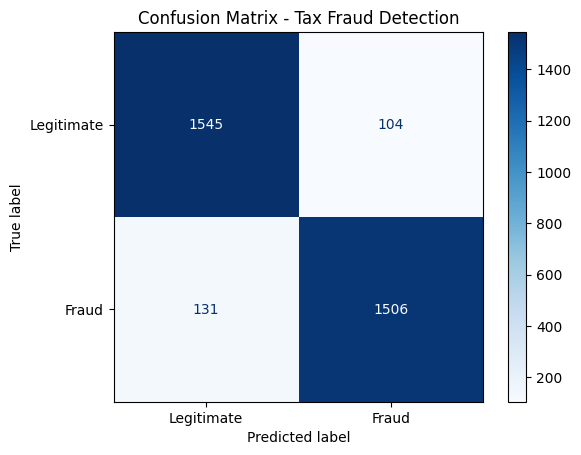

In [75]:
# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Tax Fraud Detection')
plt.show()

In [76]:
import joblib
import os

# --- IMPORTANT ---
# Make sure the variable 'model' matches the name of your
# trained model variable in the notebook.
trained_model_object = model 

# -----------------

# Define the directory and file path
model_dir = "model"
model_path = os.path.join(model_dir, "fraud_pipeline.pkl")

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the model to the file
joblib.dump(trained_model_object, model_path)

print(f"✅ Model successfully saved to: {model_path}")

✅ Model successfully saved to: model/fraud_pipeline.pkl
